In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [76]:
df = pd.read_csv('./ecom_data.csv', dtype={'product_id': 'str'})

In [77]:
columns_to_keep = [
    'date',
    'product_id',
    'traffic',
    'month',
    'doubleday',
    'near_dday',
    'end_of_month',
    'weekend',
    'other_commercial_sale',
    'day_offs',
    'week_of_month',
    'wday',
    'day_of_year'
]

df = df[columns_to_keep]

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

In [78]:
# See data
df.head()

,date,product_id,traffic,month,doubleday,near_dday,end_of_month,weekend,other_commercial_sale,day_offs,week_of_month,wday,day_of_year
0,2024-05-01,3388329772,0,5,0,0,0,0,0,1,1,3,122
1,2024-05-02,3388329772,0,5,0,0,0,0,0,0,1,4,123
2,2024-05-03,3388329772,0,5,0,0,0,0,0,0,1,5,124
3,2024-05-04,3388329772,0,5,0,1,0,1,0,0,1,6,125
4,2024-05-05,3388329772,0,5,1,0,0,1,0,0,1,7,126


In [79]:
df = df[df['product_id']=='28055739844']
df1 = df[['date','traffic']]
df1.head()

,date,traffic
28201,2024-05-01,0
28202,2024-05-02,0
28203,2024-05-03,0
28204,2024-05-04,0
28205,2024-05-05,0


In [80]:
df2 = df[['date', 'month',
    'doubleday',
    'near_dday',
    'end_of_month',
    'weekend',
    'other_commercial_sale',
    'day_offs',
    'week_of_month',
    'wday',
    'day_of_year']]
df2.head()

,date,month,doubleday,near_dday,end_of_month,weekend,other_commercial_sale,day_offs,week_of_month,wday,day_of_year
28201,2024-05-01,5,0,0,0,0,0,1,1,3,122
28202,2024-05-02,5,0,0,0,0,0,0,1,4,123
28203,2024-05-03,5,0,0,0,0,0,0,1,5,124
28204,2024-05-04,5,0,1,0,1,0,0,1,6,125
28205,2024-05-05,5,1,0,0,1,0,0,1,7,126


In [81]:
df1 = df1.set_index('date')
df1.index = pd.to_datetime(df1.index)

df1 = df1[['traffic']]

print(df1)

            traffic
date               
2024-05-01        0
2024-05-02        0
2024-05-03        0
2024-05-04        0
2024-05-05        0
...             ...
2024-12-22       14
2024-12-23       40
2024-12-24       33
2024-12-25       37
2024-12-26       29

[240 rows x 1 columns]


In [82]:
# Create 'traffic_2' as a copy of 'traffic'
df1['traffic_2'] = df1['traffic']

# Delete 'traffic' values starting from 2024-12-01 - To predict
df1.loc['2024-12-01':, 'traffic'] = None

# Display the updated DataFrame
df1.tail()

,traffic,traffic_2
date,,
2024-12-22,NaN,14
2024-12-23,NaN,40
2024-12-24,NaN,33
2024-12-25,NaN,37
2024-12-26,NaN,29


In [83]:
df2 = df2.set_index('date')
df2.index = pd.to_datetime(df2.index)
print(df2)

            month  doubleday  near_dday  end_of_month  weekend  \
date                                                             
2024-05-01      5          0          0             0        0   
2024-05-02      5          0          0             0        0   
2024-05-03      5          0          0             0        0   
2024-05-04      5          0          1             0        1   
2024-05-05      5          1          0             0        1   
...           ...        ...        ...           ...      ...   
2024-12-22     12          0          0             0        1   
2024-12-23     12          0          0             0        0   
2024-12-24     12          0          0             0        0   
2024-12-25     12          0          0             1        0   
2024-12-26     12          0          0             1        0   

            other_commercial_sale  day_offs  week_of_month  wday  day_of_year  
date                                                         

In [84]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2024-05-01 to 2024-12-26
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   traffic    214 non-null    float64
 1   traffic_2  240 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 13.7 KB


In [85]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2024-05-01 to 2024-12-26
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   month                  240 non-null    int64
 1   doubleday              240 non-null    int64
 2   near_dday              240 non-null    int64
 3   end_of_month           240 non-null    int64
 4   weekend                240 non-null    int64
 5   other_commercial_sale  240 non-null    int64
 6   day_offs               240 non-null    int64
 7   week_of_month          240 non-null    int64
 8   wday                   240 non-null    int64
 9   day_of_year            240 non-null    int64
dtypes: int64(10)
memory usage: 20.6 KB


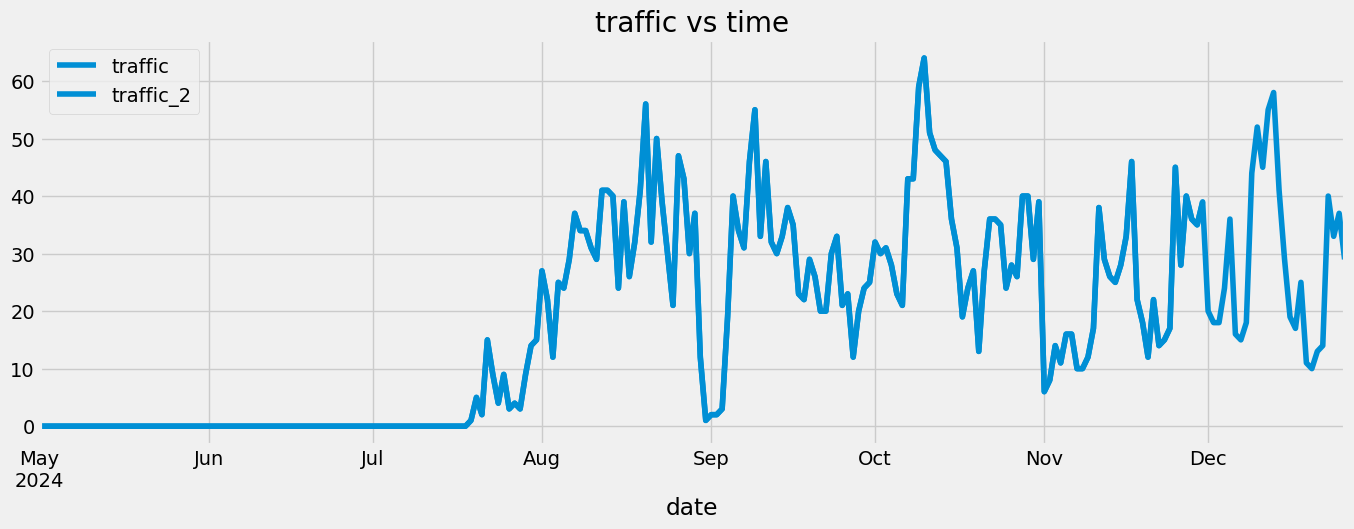

In [86]:
# Assuming df is your DataFrame and it contains a 'traffic' column
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data
df1.plot(ax=ax, style='-', color=color_pal[0], title='traffic vs time')

# Show the plot
plt.show()

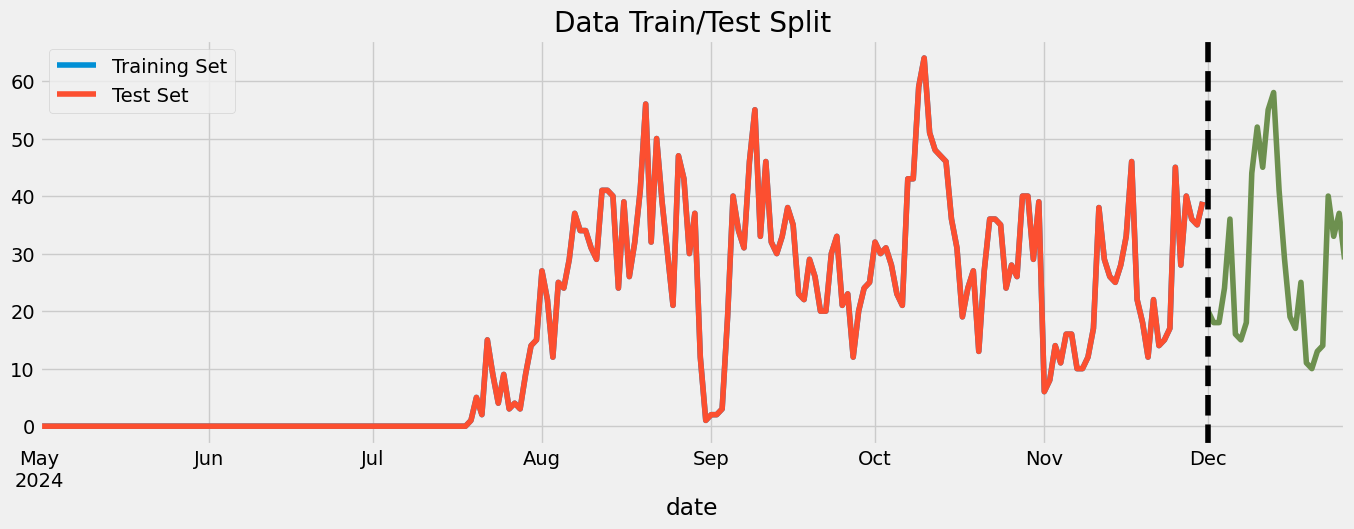

In [87]:
# Assuming df is your DataFrame and the index is a DateTimeIndex
train = df1.loc[df1.index < '2024-12-01']
test = df1.loc[df1.index >= '2024-12-01']

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the training and test datasets
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

# Add a vertical line to indicate the split point
ax.axvline('2024-12-01', color='black', ls='--')

# Add legend
ax.legend(['Training Set', 'Test Set'])

# Show the plot
plt.show()

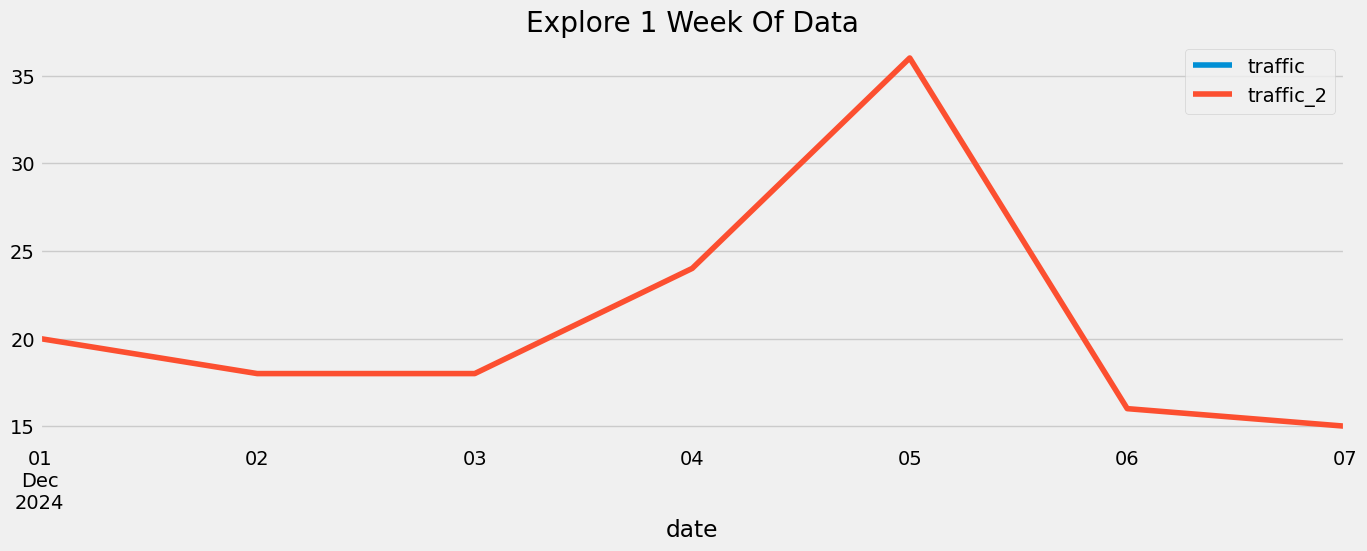

In [88]:
# Filter the DataFrame for the specified date range and plot
df1.loc[(df1.index >= '2024-12-01') & (df1.index <= '2024-12-07')] \
    .plot(figsize=(15, 5), title='Explore 1 Week Of Data')

# Get the current axes to apply the formatter
ax = plt.gca()

# Show the plot
plt.show()

## Feature Creation

In [89]:
# Create features for the DataFrame
df1['day_of_month'] = df1.index.day

In [90]:
df1 = df1.join(df2, how='left')

# For cyclical encoding, use sine/cosine transforms
def cyclical_encode(series, max_val):
    # series are values from 1 to max_val
    # Convert to 0-based: (value-1)
    sine = np.sin(2 * np.pi * (series - 1) / max_val)
    cosine = np.cos(2 * np.pi * (series - 1) / max_val)
    return sine, cosine

# Cyclical encode weekday (7 days in a week)
df1['wday_sin'], df1['wday_cos'] = cyclical_encode(df1['wday'], 7)
# Cyclical encode month (12 months)
df1['month_sin'], df1['month_cos'] = cyclical_encode(df1['month'], 12)
# Cyclical encode week_of_the_month (assume up to 5 weeks in a month)
df1['wom_sin'], df1['wom_cos'] = cyclical_encode(df1['week_of_month'], 5)
# Cyclical encode day_of_year (assume up to 365 days in a year)
df1['day_of_year_sin'], df1['day_of_year_cos'] = cyclical_encode(df1['day_of_year'], 365)
# Cyclical encode day_of_month (assume up to 31 days in a month)
df1['day_of_month_sin'], df1['day_of_month_cos'] = cyclical_encode(df1['day_of_month'], 365)


In [91]:
# Sort the DataFrame by index in ascending order, then create lag for most recent and same time last month
df1.sort_index(inplace=True)

for lag in [1, 2, 3, 29, 30, 31]:
    df1[f'traffic_lag_{lag}'] = df1['traffic'].shift(lag)

In [92]:
# Initialize the frequency_lambda column to reward recency if lag data is recent, punish if lag data is distant in terms of days apart.
frequency_lambda = 50.00  # Start at 50%
df1['frequency_lambda'] = None
# Iteratively calculate traffic for future dates
for date in df1.index:
    if pd.isna(df1.loc[date, 'traffic']):

        # Frequency_lambda
        df1.loc[date, 'frequency_lambda'] = max(frequency_lambda, 0)
        frequency_lambda -= 5.00

In [93]:
# Iteratively calculate 'traffic' for future dates
for date in df1.index:
    if pd.isna(df1.loc[date, 'traffic']):

        # Calculate traffic for the current date
        df1.loc[date, 'traffic'] = (
            df1.loc[date, ['traffic_lag_1', 'traffic_lag_2', 'traffic_lag_3']].mean() +
            df1.loc[date, ['traffic_lag_29', 'traffic_lag_30', 'traffic_lag_31']].mean()
        ) / 2

        # Assign traffic to 'traffic_lag_1' for the next date
        next_idx = df1.index.get_loc(date) + 1
        if next_idx < len(df1.index):  # Ensure we don't go out of bounds
            next_date = df1.index[next_idx]

            # Update lags for the next date based on current date's calculations
            df1.loc[next_date, 'traffic_lag_1'] = df1.loc[date, 'traffic']
            df1.loc[next_date, 'traffic_lag_2'] = df1.loc[date, 'traffic_lag_1']
            df1.loc[next_date, 'traffic_lag_3'] = df1.loc[date, 'traffic_lag_2']

        avg_3d = df1.loc[date, ['traffic_lag_1', 'traffic_lag_2', 'traffic_lag_3']].mean()
        avg_30d = df1.loc[date, ['traffic_lag_29', 'traffic_lag_30', 'traffic_lag_31']].mean()

        if df1.loc[date, 'frequency_lambda'] > 0:
            freq = df1.loc[date, 'frequency_lambda'] / 100  # Convert percentage to fraction
            df1.loc[date, 'traffic'] = (avg_3d * freq) + (avg_30d * (1 - freq))
        else:
            df1.loc[date, 'traffic'] = avg_30d

df1.tail()

,traffic,traffic_2,day_of_month,month,doubleday,near_dday,end_of_month,weekend,other_commercial_sale,day_offs,...,day_of_year_cos,day_of_month_sin,day_of_month_cos,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_29,traffic_lag_30,traffic_lag_31,frequency_lambda
date,,,,,,,,,,,,,,,,,,,,,
2024-12-22,17.000000,14,22,12,0,0,0,1,0,0,...,0.988023,0.353676,0.935368,20.504733,22.498867,23.627657,15.0,14.0,22.0,0
2024-12-23,15.333333,40,23,12,0,0,0,0,1,0,...,0.990532,0.369725,0.929141,19.605210,20.504733,22.498867,17.0,15.0,14.0,0
2024-12-24,25.666667,33,24,12,0,0,0,0,1,0,...,0.992749,0.385663,0.922640,18.101468,19.605210,20.504733,45.0,17.0,15.0,0
2024-12-25,30.000000,37,25,12,0,0,1,0,1,0,...,0.994671,0.401488,0.915864,22.535235,18.101468,19.605210,28.0,45.0,17.0,0
2024-12-26,37.666667,29,26,12,0,0,1,0,0,0,...,0.996298,0.417194,0.908818,25.040319,22.535235,18.101468,40.0,28.0,45.0,0


In [94]:
# Ad spend during promotion, weekend
# if 'doubleday' in df1.columns and 'traffic_lag_1' in df1.columns:
#     df1['doubleday_traffic_lag_1'] = df1['doubleday'] * df1['traffic_lag_1']

# # Ad spend during promotion, weekend
# if 'doubleday' in df1.columns and 'traffic_lag_2' in df1.columns:
#     df1['doubleday_traffic_lag_2'] = df1['doubleday'] * df1['traffic_lag_2']

# if 'doubleday' in df1.columns and 'traffic_lag_3' in df1.columns:
#     df1['doubleday_traffic_lag_3'] = df1['doubleday'] * df1['traffic_lag_3']


# if 'doubleday' in df1.columns and 'traffic_lag_29' in df1.columns:
#     df1['doubleday_traffic_lag_29'] = df1['doubleday'] * df1['traffic_lag_29']


if 'doubleday' in df1.columns and 'traffic_lag_30' in df1.columns:
    df1['doubleday_traffic_lag_30'] = df1['doubleday'] * df1['traffic_lag_30']

if 'doubleday' in df1.columns and 'traffic_lag_31' in df1.columns:
    df1['doubleday_traffic_lag_31'] = df1['doubleday'] * df1['traffic_lag_31']

In [95]:
df1['begin_month'] = (df1['day_of_month'] <= 7).astype(int)

In [96]:
train = df1.loc[df1.index < '2024-12-01']
test = df1.loc[df1.index >= '2024-12-01']

train.head()

,traffic,traffic_2,day_of_month,month,doubleday,near_dday,end_of_month,weekend,other_commercial_sale,day_offs,...,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_29,traffic_lag_30,traffic_lag_31,frequency_lambda,doubleday_traffic_lag_30,doubleday_traffic_lag_31,begin_month
date,,,,,,,,,,,,,,,,,,,,,
2024-05-01,0.0,0,1,5,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,1
2024-05-02,0.0,0,2,5,0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,1
2024-05-03,0.0,0,3,5,0,0,0,0,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,None,NaN,NaN,1
2024-05-04,0.0,0,4,5,0,1,0,1,0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,None,NaN,NaN,1
2024-05-05,0.0,0,5,5,1,0,0,1,0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,None,NaN,NaN,1


## Create our Model

In [97]:
FEATURES = ['day_of_month',
 'month',
 'doubleday',
 'near_dday',
 'end_of_month',
 'begin_month',
 'weekend',
 'other_commercial_sale',
 'day_offs',
 'week_of_month',
 'wday',
 'day_of_year',
 'wday_sin',
 'wday_cos',
 'month_sin',
 'month_cos',
 'wom_sin',
 'wom_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_month_sin',
 'day_of_month_cos',
 'traffic_lag_1',
 'traffic_lag_2',
 'traffic_lag_3',
 'traffic_lag_29',
 'traffic_lag_30',
 'traffic_lag_31',
#  'doubleday_traffic_lag_1',
#  'doubleday_traffic_lag_2',
#  'doubleday_traffic_lag_3',
#  'doubleday_traffic_lag_29',
 'doubleday_traffic_lag_30',
 'doubleday_traffic_lag_31'
 ]
TARGET = 'traffic_2'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Initialize all weights to 1
weights = np.ones(len(X_train), dtype=np.float32)

# Boost rows where double_day == 1
# For example, multiply their weight by 5
weights[X_train['doubleday'] == 1] = 5.0

In [98]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gblinear',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=6,
                       learning_rate=0.001,
                       subsample=1,
                       colsample_bytree=1)
reg.fit(X_train, y_train, sample_weight=weights,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:23.42729	validation_1-rmse:30.94154
[100]	validation_0-rmse:11.74823	validation_1-rmse:17.36954


c:\Users\ngtran\LearningPython\time_series\time_series\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:9.89389	validation_1-rmse:14.73352
[300]	validation_0-rmse:9.28601	validation_1-rmse:14.12875
[400]	validation_0-rmse:8.89696	validation_1-rmse:13.96434
[500]	validation_0-rmse:8.60655	validation_1-rmse:13.94121
[527]	validation_0-rmse:8.53955	validation_1-rmse:13.94720


XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.001, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Feature Importance

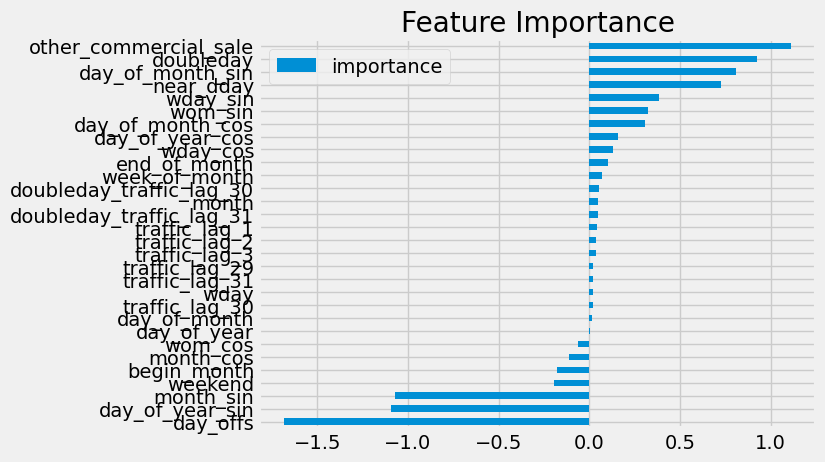

In [99]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

C:\Users\ngtran\AppData\Local\Temp\ipykernel_10536\2870831532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


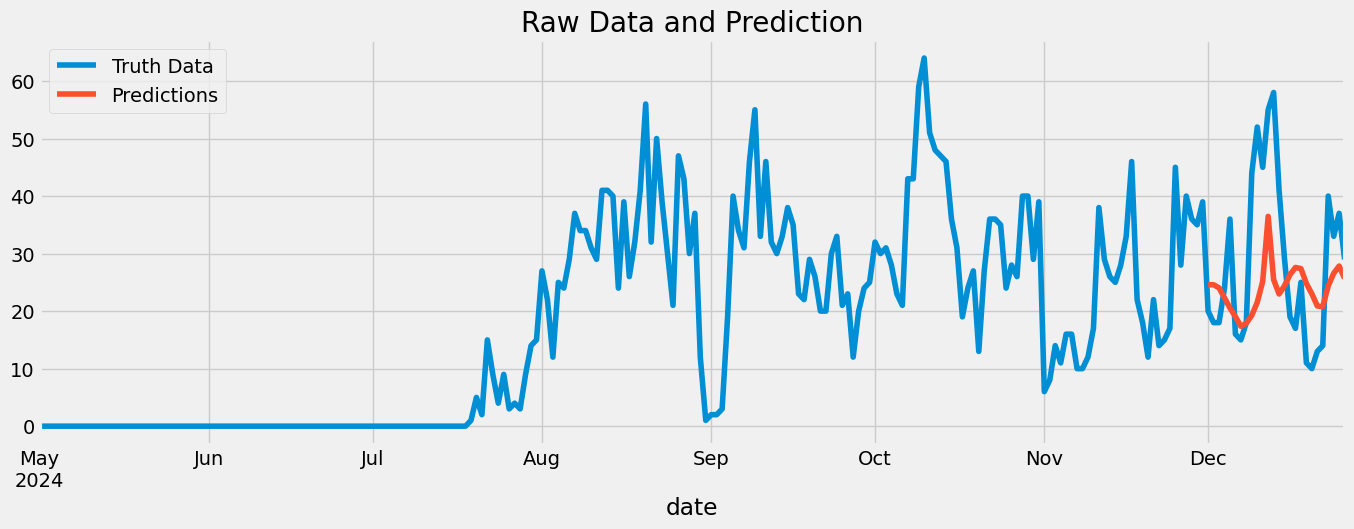

In [100]:
test['prediction'] = reg.predict(X_test)
df1 = df1.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df1[['traffic_2']].plot(figsize=(15, 5))
df1['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
# Set the y-axis formatter to display currency
# formatter = ticker.FuncFormatter(lambda x, _: f'{int(x):,} VND')
# ax.yaxis.set_major_formatter(formatter)
plt.show()